

# **College Tuition ROI Analysis**

Goal: This notebook aims to calculate a Return on Investment (ROI) metric for various US colleges using data from the College Scorecard and national earnings benchmarks.

**Data Sources**:

Most-Recent-Cohorts-Institution_05192025.csv: Institutional data from the US Department of Education's College Scorecard.

p24.xlsx: Data on median earnings by educational attainment, likely from ACS/CPS tables, used to establish baseline earnings.

First, let's import the necessary libraries (pandas for data manipulation, re for potential text processing, matplotlib, seaborn, and plotly for visualizations) and load the datasets into pandas DataFrames. Note: The DtypeWarning suggests some columns in the College Scorecard have mixed data types, which might require cleaning later.

In [19]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
College_Scorecard = pd.read_csv("Most-Recent-Cohorts-Institution_05192025.csv")
Income_by_Ed = pd.read_excel("p24.xlsx")


C:\Users\Donovan\AppData\Local\Temp\ipykernel_18316\1670060136.py:6: DtypeWarning: Columns (9,1407,1408,1431,1432,1532,1537,1538,1539,1540,1542,1546,1589,1601,1602,1606,1608,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1653,1679,1690,1692,1697,1700,1702,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984,2376,2377,2403,2404,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2958,3215,3231,3235,3236) have mixed types. Specify dtype option on import or set low_memory=False.
  College_Scorecard = pd.read_csv("Most-Recent-Cohorts-Institution_05192025.csv")


In [3]:
#this funtion grabs the median earnings from the "Income by Education levle data"
def get_median_earnings(
    path: str,
    education_level: str,
    year: int | None = None,
    dollars: str = "2024"
):
    """
    Read the ACS/CPS Table P-24 Excel export and return median earnings
    for a given education level and year.
    """
    # This block is inside the function, so it's indented 4 spaces
    raw = pd.read_excel(path, header=None, dtype=str)

    mask = raw[0].str.contains(education_level, case=False, na=False)
    if not mask.any():
        # This line is inside the 'if' block, so it's indented another 4 spaces (8 total)
        raise ValueError(f"Could not find the '{education_level}' section in the file.")
    start = mask[mask].index[0]

    # In these tables, the next row after the label is the header row for the block.
    # The data starts on start+1 and spans ~40 rows (1991–2024). We take columns A:G (0..6).
    block = raw.iloc[start+1:start+1+50, 0:7].copy()

    # Rename columns to something usable
    block.columns = [
        "Year",
        "Num_with_earnings_male",
        "Male_current",
        "Male_2024",
        "Num_with_earnings_female",
        "Female_current",
        "Female_2024",
    ]

    # Keep only rows that look like a year (e.g., "2023" or "2021 (41)")
    block["Year"] = block["Year"].astype(str).str.extract(r"(\d{4})")
    block = block[block["Year"].notna()]
    block["Year"] = block["Year"].astype(int)

    # Pick the column set (current vs 2024 dollars)
    if dollars.lower().startswith("2024"):
        male_col = "Male_2024"
        female_col = "Female_2024"
    else:
        male_col = "Male_current"
        female_col = "Female_current"

    # Clean numeric columns (remove commas, cast to float)
    for c in [male_col, female_col]:
        block[c] = (
            block[c]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("\u2212", "-", regex=False)  # in case of unicode minus
            .str.strip()
        )
        block[c] = pd.to_numeric(block[c], errors="coerce")

    # Choose target year (latest if None)
    if year is None:
        sel = block.sort_values("Year", ascending=False).iloc[0]
    else:
        rows = block[block["Year"] == year]
        if rows.empty:
            available = block["Year"].unique()
            raise ValueError(f"Year {year} not found. Available years: {sorted(available)[0]}–{sorted(available)[-1]}")
        sel = rows.iloc[0]

    male = float(sel[male_col])
    female = float(sel[female_col])
    avg = (male + female) / 2.0

    return {
        "year": int(sel["Year"]),
        "male": male,
        "female": female,
        "avg": avg,
    }
hs_baseline = get_median_earnings("p24.xlsx", education_level="High school graduate")
ba_baseline = get_median_earnings("p24.xlsx", education_level="Bachelor's Degree")

print(f"High School Baseline: {hs_baseline}")
print(f"Bachelor's Degree Baseline: {ba_baseline}")

High School Baseline: {'year': 2024, 'male': 55400.0, 'female': 42020.0, 'avg': 48710.0}
Bachelor's Degree Baseline: {'year': 2024, 'male': 103100.0, 'female': 80070.0, 'avg': 91585.0}


## **Establish Baseline Earnings**

This cell defines a function get_median_earnings designed to parse the p24.xlsx file. This file contains median earnings data broken down by education level, year, and gender.

Function Logic:

Reads the Excel file.

Finds the section corresponding to the specified education_level.

Extracts the data block for that level.

Cleans the data (extracts years, handles formatting, converts to numeric).

Selects earnings data for the target year (or latest if None) in the specified dollars (defaults to 2024-adjusted dollars).

Returns a dictionary containing the year, median male earnings, median female earnings, and the average of the two.

We then use this function to get the latest (2024) average median earnings for:

High School Graduates: This will serve as our baseline for comparison.

Bachelor's Degree Holders: Used for context or potential alternative comparisons (though not used directly in the ROI calculation later).

The output shows the calculated baselines used in subsequent steps.

In [22]:
#Now i need to make a more useful version of College_Board/Clean Data
cols = ["INSTNM", "STABBR", "MD_EARN_WNE_P10", "COSTT4_A"]
roi_df = College_Scorecard[cols].copy()
#Handeling "Privetly Supressed"
roi_df = roi_df[~roi_df["MD_EARN_WNE_P10"].astype(str).str.contains("PS")]
roi_df = roi_df[~roi_df["COSTT4_A"].astype(str).str.contains("PS")]
roi_df["MD_EARN_WNE_P10"] = pd.to_numeric(roi_df["MD_EARN_WNE_P10"], errors="coerce")
roi_df["COSTT4_A"] = pd.to_numeric(roi_df["COSTT4_A"], errors="coerce")
roi_df = roi_df.dropna().reset_index(drop=True)
roi_df = roi_df.rename(columns={
    "MD_EARN_WNE_P10": "earn_10yr",
    "COSTT4_A": "Cost_Per_Year",
    "INSTNM": "School",
    "STABBR": "State"
})
#I am also going to create a new "Total cost" by Cost_Per_Year*4
roi_df["Total_Cost"] = roi_df['Cost_Per_Year'] * 4


## **Prepare College Scorecard Data**

Now, we process the College_Scorecard data to isolate the columns relevant for our ROI calculation and clean them.

### **Steps**:

Select Columns: We choose the institution name (INSTNM), state (STABBR), median 10-year earnings (MD_EARN_WNE_P10), and average annual cost (COSTT4_A).

Handle Suppressed Data: The College Scorecard uses "PS" (Privacy Suppressed) for some values. We remove rows where earnings or cost are marked as "PS".

Convert to Numeric: We convert the earnings and cost columns to numeric types. errors="coerce" turns any values that can't be converted (like remaining non-numeric strings) into NaN (Not a Number).

Drop Missing Values: We remove any rows that contain NaN values resulting from the coercion or missing data.

Rename Columns: We rename the columns to be more descriptive (earn_10yr, Cost_Per_Year, School, State).

Calculate Total Cost: We estimate the Total_Cost of a 4-year degree by multiplying the Cost_Per_Year by 4. Note: This is a simplification; actual total cost can vary based on factors like time-to-degree and specific program costs.

The resulting roi_df DataFrame contains the cleaned data ready for ROI metric calculation.

In [25]:
#Now lets add a new collunm, the earn priemium, or the difrrence between the avg highschool grad salary and someone with a degree
roi_df["earn_premium"] = roi_df["earn_10yr"] - hs_baseline["avg"]
roi_df
#some school have negitive earn_premiums

,School,State,earn_10yr,Cost_Per_Year,Total_Cost,earn_premium
0,Alabama A & M University,AL,40628.0,23751.0,95004.0,-8082.0
1,University of Alabama at Birmingham,AL,54501.0,27826.0,111304.0,5791.0
2,University of Alabama in Huntsville,AL,61767.0,27098.0,108392.0,13057.0
3,Alabama State University,AL,34502.0,22028.0,88112.0,-14208.0
4,The University of Alabama,AL,59221.0,32024.0,128096.0,10511.0
...,...,...,...,...,...,...
3070,Arizona College of Nursing-Falls Church,VA,34657.0,38123.0,152492.0,-14053.0
3071,Arizona College of Nursing-Ontario,CA,34657.0,43703.0,174812.0,-14053.0
3072,Galen Health Institutes-Pikeville,KY,61480.0,42163.0,168652.0,12770.0
3073,Commonwealth University of Pennsylvania,PA,52416.0,25781.0,103124.0,3706.0


## **Calculate Earnings Premium**

The first key ROI metric is the Earnings Premium. This represents how much more (or less) the median graduate from a specific college earns 10 years after entry compared to the average high school graduate baseline calculated earlier (hs_baseline["avg"]).

We calculate this by subtracting the high school baseline average earnings from each school's earn_10yr.

Observation: As noted in the code comment, some schools show a negative earnings premium. This suggests that, based on this data, the median graduate from these institutions earns less 10 years after entry than the average high school graduate nationwide. This could be due to various factors, including the specific programs offered, regional economic differences, student demographics, or data limitations.

In [26]:
#Now we are going to see how long it takes per school to "break even" on your investment
roi_df['break_even_years'] = roi_df['Total_Cost'] / roi_df['earn_premium']
roi_df

,School,State,earn_10yr,Cost_Per_Year,Total_Cost,earn_premium,break_even_years
0,Alabama A & M University,AL,40628.0,23751.0,95004.0,-8082.0,-11.755011
1,University of Alabama at Birmingham,AL,54501.0,27826.0,111304.0,5791.0,19.220169
2,University of Alabama in Huntsville,AL,61767.0,27098.0,108392.0,13057.0,8.301447
3,Alabama State University,AL,34502.0,22028.0,88112.0,-14208.0,-6.201577
4,The University of Alabama,AL,59221.0,32024.0,128096.0,10511.0,12.186852
...,...,...,...,...,...,...,...
3070,Arizona College of Nursing-Falls Church,VA,34657.0,38123.0,152492.0,-14053.0,-10.851206
3071,Arizona College of Nursing-Ontario,CA,34657.0,43703.0,174812.0,-14053.0,-12.439479
3072,Galen Health Institutes-Pikeville,KY,61480.0,42163.0,168652.0,12770.0,13.206891
3073,Commonwealth University of Pennsylvania,PA,52416.0,25781.0,103124.0,3706.0,27.826228


## **Calculate Break-Even Years**

The second key ROI metric is the Break-Even Years. This estimates how many years it would take for the additional earnings gained by attending college (the earn_premium) to cover the Total_Cost of the degree.

We calculate this by dividing the Total_Cost by the earn_premium.

### **Interpretation**:

A lower positive number indicates a faster return on the financial investment.

A negative number here results from a negative earn_premium. It implies that, based on these metrics, the cost of the degree would never be recouped through the earnings premium alone, as the graduate earns less than the baseline.

Very high positive numbers suggest a very long payback period.

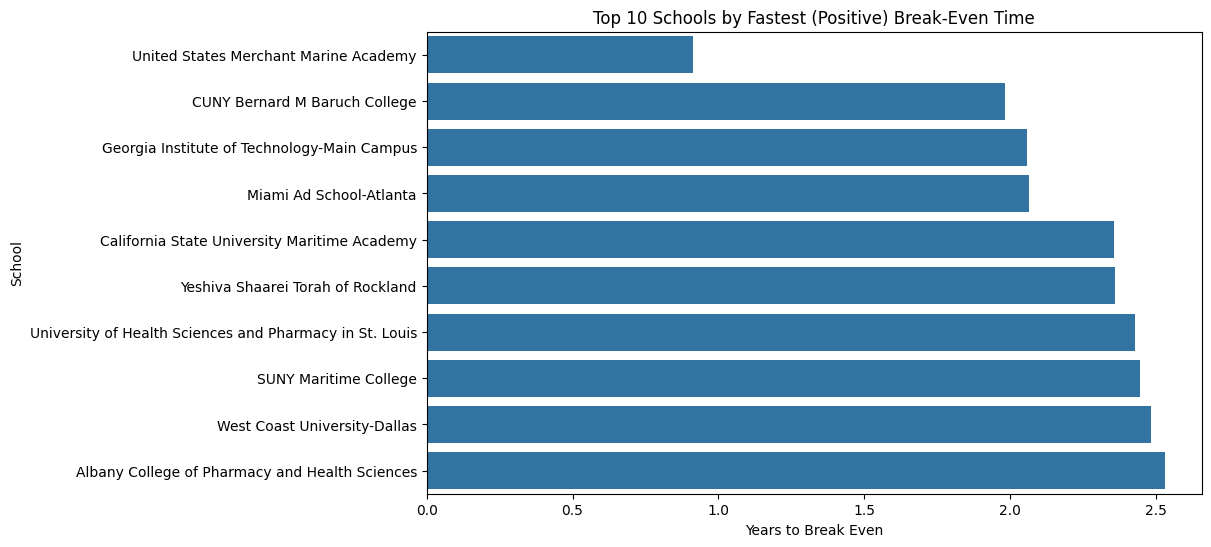

In [27]:
positive_roi_df = roi_df[roi_df['break_even_years'] > 0]

# Now, get the 10 smallest (fastest) from that filtered list
top_10_roi = positive_roi_df.nsmallest(10, 'break_even_years')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_roi,
    x='break_even_years',
    y='School' 
)
plt.title('Top 10 Schools by Fastest (Positive) Break-Even Time')
plt.xlabel('Years to Break Even')
plt.ylabel('School')
plt.show()

## **Visualize Top ROI Schools (Break-Even Time)**

To identify the schools offering the quickest practical financial return, we must first filter out the schools with a negative break-even time (which, as discussed, represent an investment that is never paid back).

### **Steps**:

Filter: We create a new DataFrame, positive_roi_df, which contains only the institutions where the break_even_years is a positive number.

Select Top 10: From this filtered list, we use .nsmallest(10, ...) to find the 10 schools with the fastest (lowest) positive payback periods.

Plot: We then use seaborn to create a bar chart of these 10 schools.

This visualization now clearly and logically displays the "Top 10" schools, showing the number of years required to pay back the educational investment purely from their median earnings premium.

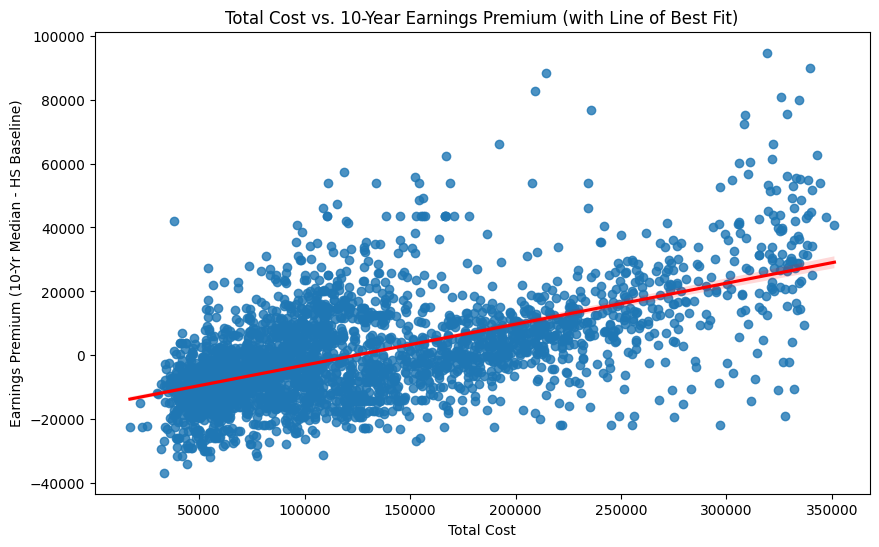

In [16]:
# Create a scatter plot of cost vs. earnings premium
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=roi_df, 
    x='Total_Cost', 
    y='earn_premium',
    line_kws={"color":"red"} # Optional: makes the line red and easy to see
)
plt.title('Total Cost vs. 10-Year Earnings Premium (with Line of Best Fit)')
plt.xlabel('Total Cost')
plt.ylabel('Earnings Premium (10-Yr Median - HS Baseline)')
plt.show()

## **Visualize Cost vs. Earnings Premium Relationship**

This scatter plot explores the relationship between the estimated Total_Cost of a degree (x-axis) and the calculated earn_premium (y-axis) for all schools in our cleaned dataset.

We use seaborn's regplot, which automatically adds:

A Line of Best Fit (Linear Regression Line): Shown in red, this line indicates the general trend. A positive slope suggests that, on average, higher-cost institutions tend to correlate with higher earnings premiums.

A 95% Confidence Interval: The shaded area around the line represents the uncertainty in the estimated trend line. A wider band indicates more variability or less certainty in the relationship.

This visualization helps understand if investing more in tuition generally corresponds to a higher earnings advantage over the baseline. The scatter of points also reveals the wide variation among individual institutions.

In [ ]:
# 1. Group by state and get the average ROI
state_roi = roi_df.groupby('State')['break_even_years'].mean().reset_index()

# 2. Create the choropleth map
fig = px.choropleth(
    state_roi,
    locations='State',          # Column with state abbreviations
    locationmode="USA-states", # Set to use state abbreviations
    color='break_even_years',  # Column to determine the color
    color_continuous_scale="Viridis_r", # 'r' reverses the color map (lower is better)
    scope="usa",               # Focus on the USA
    title="Average Break-Even Years by State"
)

fig.show()

## **Visualize Average ROI by State (Choropleth Map)**

To see geographic trends, we create a choropleth map showing the average break_even_years for colleges within each US state.

### **Steps**:

Group by State: We group the roi_df DataFrame by the State column and calculate the mean (average) break_even_years for each state.

Create Map: We use plotly.express to generate the map:

locations='State' uses the state abbreviations for mapping.

locationmode="USA-states" tells Plotly to interpret locations as US states.

color='break_even_years' assigns color intensity based on the average break-even time.

color_continuous_scale="Viridis_r" uses the Viridis color scale, reversed (_r) so that lower (better) break-even times appear in brighter/yellow colors and higher times are darker/purple.

scope="usa" focuses the map view on the United States.

This interactive map helps identify regions where the average estimated return on college investment appears faster or slower based on our metrics.

# **Conclusion**

This analysis calculated two ROI metrics (Earnings Premium and Break-Even Years) for US colleges based on College Scorecard data and national earnings benchmarks.

## **Key Findings**:

There is significant variation in estimated ROI across institutions. Some show a rapid break-even time, while others have a negative earnings premium relative to the high school baseline.

Visualizations indicate a slight positive trend between total cost and earnings premium, although with considerable variance (shown by the scatter plot and confidence interval).

Geographic differences exist, with some states showing lower average break-even times than others (shown by the choropleth map).

## **Limitations**: 
This analysis relies on median earnings 10 years after entry and average cost estimates. It doesn't account for variations by major, individual student outcomes, time-to-graduation differences, or other non-financial benefits of education. The negative premiums and break-even times highlight potential limitations of applying these broad metrics universally.